--- Initial Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Rk                 303 non-null    int64  
 1   Player             303 non-null    object 
 2   Age                303 non-null    int64  
 3   Team               303 non-null    object 
 4   Pos                303 non-null    object 
 5   G                  303 non-null    int64  
 6   GS                 303 non-null    int64  
 7   MP                 303 non-null    int64  
 8   PER                303 non-null    float64
 9   TS%                303 non-null    float64
 10  3PAr               303 non-null    float64
 11  FTr                303 non-null    float64
 12  ORB%               303 non-null    float64
 13  DRB%               303 non-null    float64
 14  TRB%               303 non-null    float64
 15  AST%               303 non-null    float64
 16  

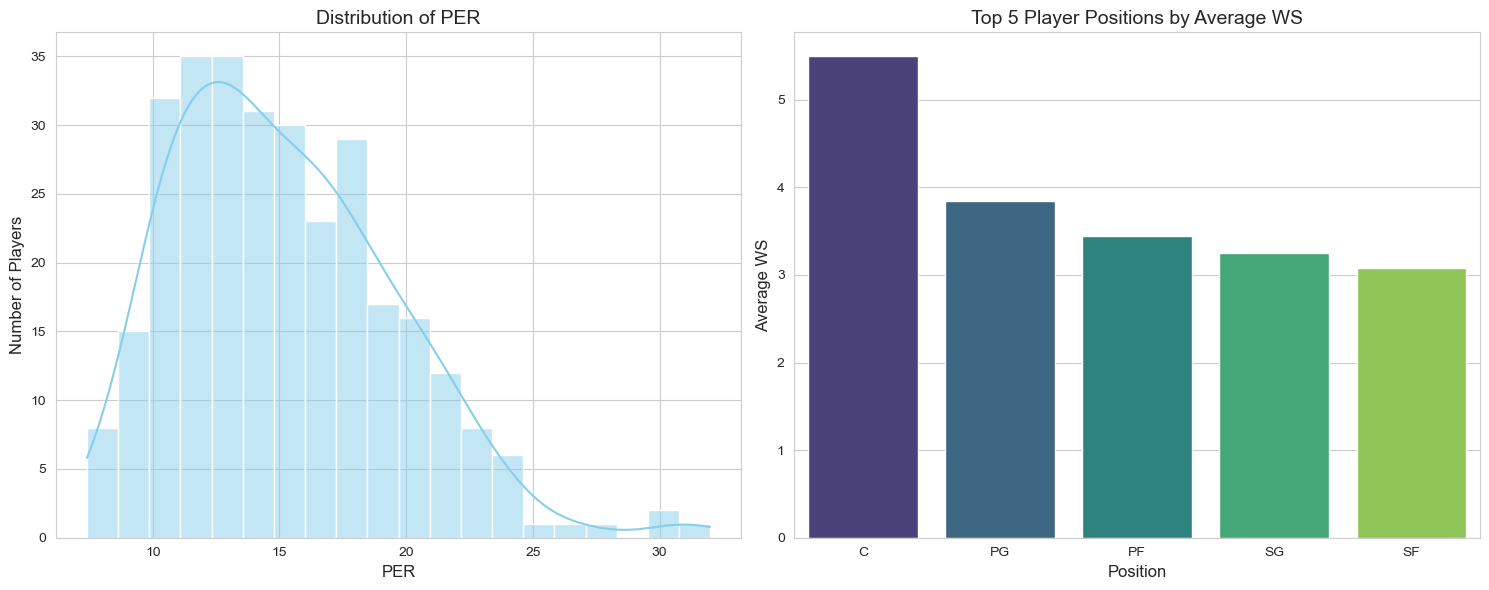

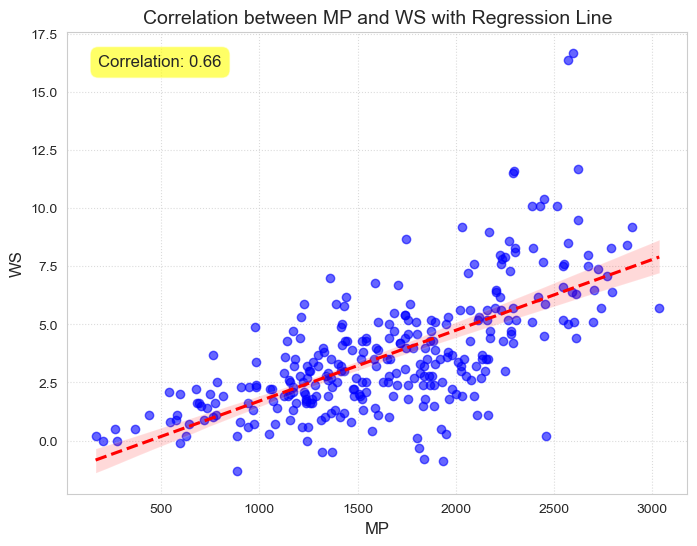

In [3]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Load the dataset ---
# Loading the NBA player statistics dataset
df = pd.read_csv('NBA FINAL CAPSTONE_UTF8.csv')

# --- 2. Initial Data Info and Cleaning (I.B.1 & I.B.2) ---
print("--- Initial Data Info ---")
# Displaying initial information about the DataFrame
df.info()
print("\nMissing values before cleaning:")
# Checking for missing values before cleaning
print(df.isnull().sum())

# Drop the 'Awards' column as it contains all null values,
# which ensures sufficient data points remain for analysis.
if 'Awards' in df.columns and df['Awards'].isnull().all():
    df_cleaned = df.drop(columns=['Awards'])
    print("\nDropped 'Awards' column due to all null values.")
else:
    df_cleaned = df.copy() # If 'Awards' column is not entirely null, create a copy.

# Check for and drop any remaining nulls in other columns.
initial_rows = len(df_cleaned)
df_cleaned = df_cleaned.dropna()
rows_after_dropping = len(df_cleaned)

if initial_rows - rows_after_dropping > 0:
    print(f"\nDropped {initial_rows - rows_after_dropping} rows with null values (excluding 'Awards' column).")
else:
    print("\nNo additional rows with null values were dropped after removing 'Awards' column.")

print("\n--- After Cleaning ---")
# Displaying information about the DataFrame after cleaning
df_cleaned.info()
print("\nMissing values after cleaning:")
# Verifying no missing values remain
print(df_cleaned.isnull().sum())

print("\nNumber of data points after cleaning:", len(df_cleaned))
print("\nFirst 5 rows of the cleaned dataset:")
# Displaying the first few rows of the cleaned data
print(df_cleaned.head())

# Asserting that the dataset contains at least 100 data points as required
assert len(df_cleaned) >= 100, "Dataset has fewer than 100 data points after cleaning!"
print("\nDataset is clean and contains at least 100 data points.")


# --- 3. Process and analyze data using Python (I.B.3) ---

# Identifying numerical columns suitable for statistical operations.
numerical_cols = df_cleaned.select_dtypes(include=np.number).columns.tolist()
# Removing 'Rk' (Rank) as it is an identifier, not a statistical measure.
if 'Rk' in numerical_cols:
    numerical_cols.remove('Rk')

# Defining key columns to be used for NumPy, SciPy, and Statsmodels operations.
col_mp = 'MP' # Minutes Played
col_ws = 'WS' # Win Shares
col_per = 'PER' # Player Efficiency Rating
col_age = 'Age'
col_games = 'G' # Games Played

# Ensuring that all selected columns are present in the cleaned DataFrame.
selected_analysis_cols = [col_mp, col_ws, col_per, col_age, col_games]
for col in selected_analysis_cols:
    if col not in df_cleaned.columns:
        raise ValueError(f"Required column '{col}' for analysis not found in the cleaned DataFrame.")

print(f"\nUsing columns for analysis: {col_mp}, {col_ws}, {col_per}, {col_age}, {col_games}")

# Five NumPy operations
print("\n--- NumPy Operations ---")
# Operation 1: Calculate the mean of 'Minutes Played'.
mp_mean = np.mean(df_cleaned[col_mp])
print(f"1. Mean {col_mp}: {mp_mean:.2f}")

# Operation 2: Calculate the standard deviation of 'Win Shares'.
ws_std = np.std(df_cleaned[col_ws])
print(f"2. Standard Deviation {col_ws}: {ws_std:.2f}")

# Operation 3: Find the maximum value of 'Player Efficiency Rating'.
per_max = np.max(df_cleaned[col_per])
print(f"3. Max {col_per}: {per_max:.2f}")

# Operation 4: Calculate the median of 'Age'.
age_median = np.median(df_cleaned[col_age])
print(f"4. Median {col_age}: {age_median:.2f}")

# Operation 5: Count players who played more than the average number of games.
avg_games = np.mean(df_cleaned[col_games])
high_game_players_count = np.sum(df_cleaned[col_games] > avg_games)
print(f"5. Number of players who played more than average games ({avg_games:.2f}): {high_game_players_count}")

# One SciPy operation: Independent T-test
print("\n--- SciPy Operation (Independent T-test) ---")
# Performing an independent t-test to compare 'Minutes Played'
# between players with high PER (above median) and low PER (below median).
median_per = np.median(df_cleaned[col_per])
group_high_per_mp = df_cleaned[df_cleaned[col_per] >= median_per][col_mp]
group_low_per_mp = df_cleaned[df_cleaned[col_per] < median_per][col_mp]

if len(group_high_per_mp) > 1 and len(group_low_per_mp) > 1:
    # Using Welch's t-test (equal_var=False) as group variances might differ.
    t_stat, p_value = stats.ttest_ind(group_high_per_mp, group_low_per_mp, equal_var=False)
    print(f"Independent t-test between {col_mp} for High {col_per} vs. Low {col_per} players:")
    print(f"  T-statistic: {t_stat:.3f}")
    print(f"  P-value: {p_value:.3f}")
    if p_value < 0.05:
        print("  (Result: Statistically significant difference)")
    else:
        print("  (Result: No statistically significant difference)")
else:
    print(f"Not enough data in groups for t-test for columns {col_mp} and {col_per}.")

# One Statsmodels operation: Ordinary Least Squares (OLS) Linear Regression
print("\n--- Statsmodels Operation (Linear Regression) ---")
# Setting 'Win Shares' (WS) as the dependent variable (Y) and 'Minutes Played' (MP) as the independent variable (X).
X = df_cleaned[col_mp]
Y = df_cleaned[col_ws]
# Adding a constant term to the independent variable for the intercept of the regression line.
X = sm.add_constant(X)

# Fitting the OLS model.
model = sm.OLS(Y, X).fit()
# Displaying the summary of the regression model.
print(model.summary())


# --- 4. Create at least two visualizations of the data (I.B.4) ---
plt.figure(figsize=(15, 6))
# Setting Seaborn style for enhanced aesthetics (bonus requirement).
sns.set_style("whitegrid")

# Visualization 1: Distribution of Player Efficiency Rating (PER)
plt.subplot(1, 2, 1)
sns.histplot(df_cleaned[col_per], kde=True, bins=20, color='skyblue')
plt.title(f'Distribution of {col_per}', fontsize=14)
plt.xlabel(col_per, fontsize=12)
plt.ylabel('Number of Players', fontsize=12)

# Visualization 2: Bar plot of average Win Shares (WS) by Player Position (Top 5 positions)
# Calculating average Win Shares for each position and selecting the top 5.
avg_ws_by_pos = df_cleaned.groupby('Pos')[col_ws].mean().nlargest(5).sort_values(ascending=False)
plt.subplot(1, 2, 2)
# Using 'hue' argument to address a Seaborn FutureWarning regarding palette usage.
sns.barplot(x=avg_ws_by_pos.index, y=avg_ws_by_pos.values, hue=avg_ws_by_pos.index, palette='viridis')
plt.title(f'Top 5 Player Positions by Average {col_ws}', fontsize=14)
plt.xlabel('Position', fontsize=12)
plt.ylabel(f'Average {col_ws}', fontsize=12)
# Removing the legend for this plot as the x-axis labels are sufficient.
if plt.gca().get_legend() is not None:
    plt.gca().get_legend().remove()
plt.tight_layout()
plt.show()

# --- 5. Create a correlation plot with a regression line (I.B.5) ---
plt.figure(figsize=(8, 6))
# Setting Seaborn style for enhanced aesthetics.
sns.set_style("whitegrid")

# Selecting 'Minutes Played' and 'Win Shares' for correlation analysis.
# These variables are chosen because they exhibit a meaningful relationship without being trivially dependent.
corr_var1 = col_mp
corr_var2 = col_ws

# Creating a scatter plot with a linear regression line.
sns.regplot(x=df_cleaned[corr_var1], y=df_cleaned[corr_var2], scatter_kws={'alpha':0.6, 'color':'blue'}, line_kws={'color':'red', 'linestyle':'--'})
plt.title(f'Correlation between {corr_var1} and {corr_var2} with Regression Line', fontsize=14)
plt.xlabel(corr_var1, fontsize=12)
plt.ylabel(corr_var2, fontsize=12)
plt.grid(True, linestyle=':', alpha=0.7)

# Calculating and displaying the Pearson correlation coefficient on the plot.
correlation = df_cleaned[corr_var1].corr(df_cleaned[corr_var2])
plt.text(0.05, 0.95, f'Correlation: {correlation:.2f}', transform=plt.gca().transAxes,
         fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.6))

plt.show()